1.Last name: Liu

2.Date: 1/30/2020

3.Conclusion:

4.AUC:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc, roc_curve, classification_report


import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch


## Load data

In [179]:
train = pd.read_csv('train.csv')
train.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0


In [180]:
test = pd.read_csv('test.csv')
test.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure
0,34,0.005134,Android,F,1,40376,1,3,7
1,53,0.005223,desktop,F,1,84511,1,1,11
2,46,0.004939,laptop,F,0,79322,1,1,4
3,36,0.004924,Android,F,0,63295,1,2,0
4,28,0.005146,other,F,1,36170,1,3,3


In [185]:
# change data type
train.in_initial_launch_location = train.in_initial_launch_location.astype(str)

In [186]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9731 non-null object
in_initial_launch_location    10000 non-null object
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
outcome                       10000 non-null int64
dtypes: float64(1), int64(6), object(3)
memory usage: 781.3+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9751 non-null object
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 703.2+ KB


## Remove missing values

In [188]:
print('train missing value:\n\n', train.isnull().sum(),'\n\ntest missing value:\n\n',test.isnull().sum())
print('\n We could find that there missing values (gender) both in test data and trainning data \nand the outcome is the target value')
print('Train missing gender value rate:', round(269/train.count().values[0] *100, 2), '%'
      '\nTest missing gender value rate:',round( 249/train.count().values[0] *100, 2 ), '%')

train missing value:

 age                             0
cost_of_ad                      0
device_type                     0
gender                        269
in_initial_launch_location      0
income                          0
n_drivers                       0
n_vehicles                      0
prior_ins_tenure                0
outcome                         0
dtype: int64 

test missing value:

 age                             0
cost_of_ad                      0
device_type                     0
gender                        249
in_initial_launch_location      0
income                          0
n_drivers                       0
n_vehicles                      0
prior_ins_tenure                0
dtype: int64

 We could find that there missing values (gender) both in test data and trainning data 
and the outcome is the target value
Train missing gender value rate: 2.69 %
Test missing gender value rate: 2.49 %


In [189]:
# drop missing value of train data
train.dropna(axis = 0, how ='any', inplace = True)
# sepreate missing value of test data
test1 = test.dropna(axis = 0, how = 'any')
test2 = test[test.gender.isnull()]

In [190]:
for i in train.columns:
    uniques = sorted(train[i].unique())
    print('{0:25s}{1:10d}'.format(i, len(uniques)), uniques[:5])

age                              45 [16, 17, 18, 19, 20]
cost_of_ad                     9716 [0.003170567, 0.003190502, 0.003190587, 0.003196536, 0.003201041]
device_type                       5 ['Android', 'desktop', 'iPhone', 'laptop', 'other']
gender                            2 ['F', 'M']
in_initial_launch_location         2 ['0', '1']
income                         9028 [16241, 16375, 16753, 16812, 17081]
n_drivers                         2 [1, 2]
n_vehicles                        3 [1, 2, 3]
prior_ins_tenure                 23 [0, 1, 2, 3, 4]
outcome                           2 [0, 1]


## Exploaratory data analysis

In [191]:
train.describe()

,age,cost_of_ad,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
count,9731.000000,9731.000000,9731.000000,9731.000000,9731.000000,9731.000000,9731.000000
mean,37.978933,0.004678,58015.171000,1.496557,1.998150,5.401706,0.099990
std,13.036855,0.000838,17299.989819,0.500014,0.817333,5.042682,0.300002
min,16.000000,0.003171,16241.000000,1.000000,1.000000,0.000000,0.000000
25%,27.000000,0.004010,45564.500000,1.000000,1.000000,1.000000,0.000000
50%,38.000000,0.004640,58094.000000,1.000000,2.000000,4.000000,0.000000
75%,49.000000,0.005168,70224.000000,2.000000,3.000000,8.000000,0.000000
max,60.000000,0.007082,99956.000000,2.000000,3.000000,22.000000,1.000000


In [192]:
print('There are', round(train[train['outcome']== 0].count().values[0]/train.count().values[0]*100, 2),
      '% outcome values are 0')
print('There are', round(train[train['gender']== 'F'].count().values[0]/train.count().values[0]*100, 2),
      '% gender values are F')

There are 90.0 % outcome values are 0
There are 51.07 % gender values are F


  gender   outcome
0      F  0.058954
1      M  0.142827


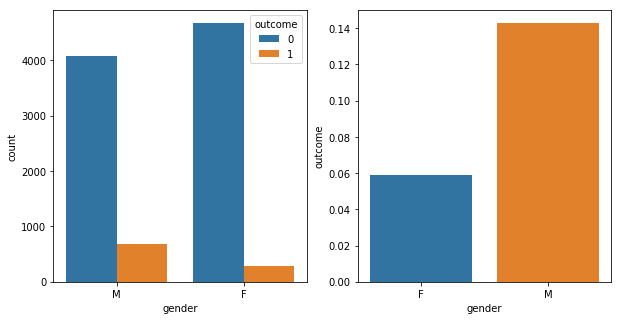

In [197]:
gender = train[['gender', 'outcome']].groupby('gender').mean().reset_index()
print(gender)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
sns.countplot(x = 'gender', hue = 'outcome', data = train, ax = ax[0])
sns.barplot(x = 'gender', y = 'outcome', data = gender, ax = ax[1])
plt.show()

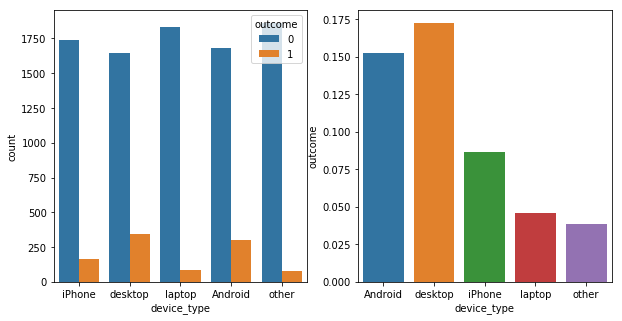

In [198]:
device_type = train[['device_type', 'outcome']].groupby('device_type').mean().reset_index()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
sns.countplot(x = 'device_type', hue = 'outcome', data = train, ax = ax[0])
sns.barplot(x = 'device_type', y = 'outcome', data = device_type, ax = ax[1])
plt.show()

    age   outcome
1    17  0.172897
3    19  0.161435
44   60  0.146018
42   58  0.135514
6    22  0.133891


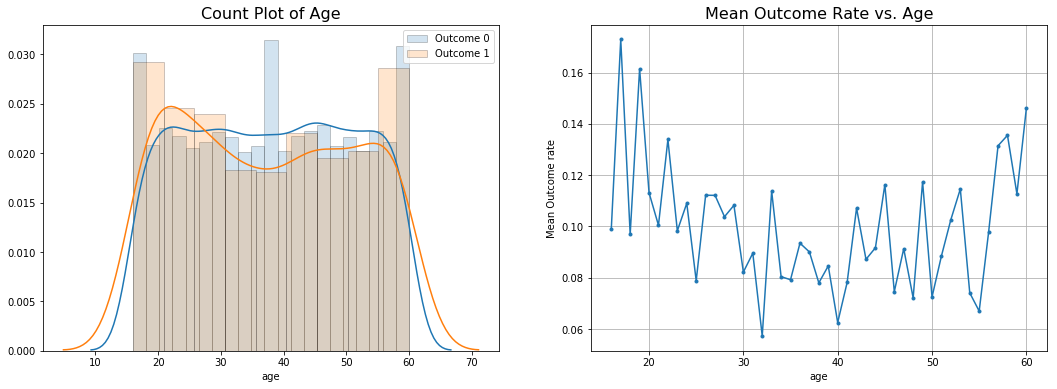

In [199]:
age = train[['age', 'outcome']].groupby('age').mean().reset_index()
print(age.sort_values(by = 'outcome', ascending = False).head())
data = train
# visualization of different age
grouped = data[['age', 'outcome']].groupby('age').mean().reset_index()

hist_kws= {'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}

fig,ax = plt.subplots(nrows=1, ncols= 2, figsize = (18,6))
sns.distplot(data[data['outcome']== 0]['age'], label= 'Outcome 0',
           ax= ax[0], hist_kws = hist_kws)
sns.distplot(data[data['outcome']== 1]['age'], label= 'Outcome 1',
           ax= ax[0], hist_kws = hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['outcome'], '.-')
ax[1].set_title('Mean Outcome Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean Outcome rate')
ax[1].grid(True)
plt.show()

##  Model

In [34]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.241-b07, mixed mode)
  Starting server from C:\Users\jiayi\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\jiayi\AppData\Local\Temp\tmpjng5u22l
  JVM stdout: C:\Users\jiayi\AppData\Local\Temp\tmpjng5u22l\h2o_jiayi_started_from_python.out
  JVM stderr: C:\Users\jiayi\AppData\Local\Temp\tmpjng5u22l\h2o_jiayi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,7 months and 10 days !!!
H2O cluster name:,H2O_from_python_jiayi_kmwz6c
H2O cluster total nodes:,1
H2O cluster free memory:,1.749 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [289]:
# convert data into h2o, and change relative variable into factors
h2o_df= H2OFrame(data)
h2o_df['outcome']= h2o_df['outcome'].asfactor()

h2o_df['in_initial_launch_location']= h2o_df['in_initial_launch_location'].asfactor()
# h2o_df['gender']= h2o_df['gender'].asfactor()
# h2o_df['n_drivers']= h2o_df['n_drivers'].asfactor()
# h2o_df['n_vehicles']= h2o_df['n_vehicles'].asfactor()
# h2o_df['prior_ins_tenure']= h2o_df['prior_ins_tenure'].asfactor()


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [290]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['outcome'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['age', 'cost_of_ad', 'device_type', 'gender',
       'in_initial_launch_location', 'income', 'n_drivers', 'n_vehicles',
       'prior_ins_tenure']
target = 'outcome'

In [291]:
# Build model_random forest

model = H2ORandomForestEstimator(balance_classes=True,  ntrees= 100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
#, ntrees= 100, max_depth=20, mtries=-1, seed=42, score_each_iteration=True
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


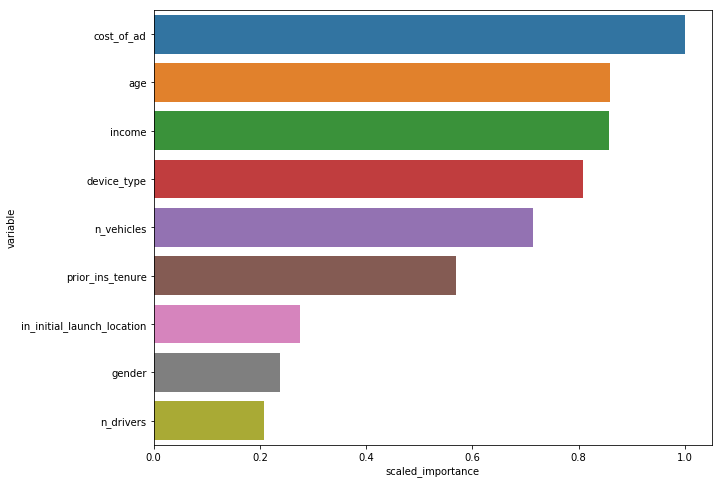

In [292]:

#model.varimp_plot()
# Feature importance
importance = model.varimp(use_pandas =True)
fig, ax= plt.subplots(figsize= (10, 8))
sns.barplot(x= 'scaled_importance', y= 'variable', data= importance)
plt.show()

In [293]:
# Make predictions
train_true = train.as_data_frame()['outcome'].values
test_true = test.as_data_frame()['outcome'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [294]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.65).astype(int)))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2190
           1       0.83      0.02      0.04       243

   micro avg       0.90      0.90      0.90      2433
   macro avg       0.87      0.51      0.49      2433
weighted avg       0.90      0.90      0.86      2433



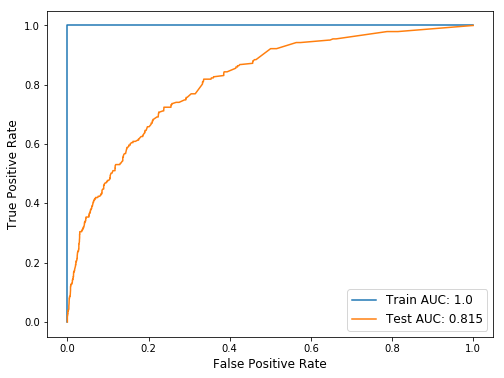

In [295]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [ ]:
# Shutdown h2o instance
h2o.cluster().shutdown()